# Introduction

Problem: Every bank experiences losses due to credit card defaults. I would like to present a data science solution: creaing a model to predict who will default. If we have a good idea of who will default, we can do something to try to prevent it (forebearance, consulting, etc.).

Objective: Predict whether or not a credit card client will default on their credit card
Audience: Lending Executives

# Target

Default payment (Yes=1, No=0)

# Features

limit_bal: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit

sex: Gender (1 = male; 2 = female)

Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)

Marital status (1 = married; 2 = single; 3 = others)

Age (year)

History of past payment. (UCI) tracked the past monthly payment records (from April to September, 2005) as follows: The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above

Amount of bill statement (NT dollar) from April to September, 2005

Amount of previous payment (NT dollar) from April to September 2005

# Import Libraries

In [16]:
# For data manipulation
import pandas as pd
import numpy as np
import psycopg2 as pg
import pickle

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# %config InlineBackend.figure_formats = ['svg']
# sns.set(style='white', palette = 'Paired')

# Modeling
from sklearn.inspection import permutation_importance
from sklearn import linear_model, svm, naive_bayes, neighbors, ensemble
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix,\
roc_auc_score, roc_curve, precision_recall_curve, fbeta_score, recall_score,\
precision_recall_fscore_support

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, 
                              AdaBoostClassifier, BaggingRegressor)
from sklearn.metrics import accuracy_score, make_scorer, log_loss

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from mlxtend.plotting import plot_decision_regions

import xgboost as xgb

# Import from PostgreSQL

In [53]:
# Postgres info to connect
connection_args = {
    'host': 'localhost',
    'dbname': 'credit_default',
    'port': 5432
}

connection = pg.connect(**connection_args)

In [54]:
query = 'SELECT * FROM customers;'

df = pd.read_sql(query, connection)

# Data Preprocessing

In [55]:
# The column names are a little odd, so let's change them
column_names = {
    'history_names': {
        'pay_0':'Sep_Hist','pay_6':'Aug_Hist','pay_2':'Jul_Hist',
        'pay_3':'Jun_Hist','pay_4':'May_Hist','pay_5':'Apr_Hist'
    },
    'balance_names': {
        'bill_amt1':'Sep_Bal','bill_amt2':'Aug_Bal','bill_amt3':'Jul_Bal',
        'bill_amt4':'Jun_Bal','bill_amt5':'May_Bal','bill_amt6':'Apr_Bal'
    },
    'payment_names': {
        'pay_amt1':'Sep_Pmt','pay_amt2':'Aug_Pmt','pay_amt3':'Jul_Pmt',
        'pay_amt4':'Jun_Pmt','pay_amt5':'May_Pmt','pay_amt6':'Apr_Pmt'
    }
}

for column_name in column_names:
    df.rename(columns=column_names[column_name], inplace=True)

df.rename(columns={'default_payment_next_month': 'Default'}, inplace=True)

In [56]:
# ID column is just an identifier, which also has no predictive value. So we remove.
df.drop(['id'], axis=1, inplace=True)

In [57]:
# Sex, education, and marriage should be categorical columns
df['sex'].replace(to_replace=['1', '2'], value=['male', 'female'], inplace=True)

df['education'].replace(to_replace=['1', '2', '3', '4', '6', '0'],
                        value=['graduate', 'university', 'highschool', 'other', 'other', 'other'],
                        inplace=True)

df['marriage'].replace(to_replace=['1', '2', '3', '0'], value=['married', 'single', 'other', 'other'], inplace=True)

In [59]:
# Let's take a look at the range of values for payment history
payment_months = ['Sep_Hist', 'Aug_Hist', 'Jul_Hist',
                  'Jun_Hist', 'May_Hist', 'Apr_Hist']

for month in payment_months:
    print(sorted(df[month].unique()))

[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
[-2, -1, 0, 2, 3, 4, 5, 6, 7, 8]
[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
[-2, -1, 0, 2, 3, 4, 5, 6, 7, 8]


In [60]:
# These ranges are pretty odd, let's change the range to 0-10, which is more reasonable
old_range = [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
new_range = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for month in payment_months:
    df[month].replace(to_replace=old_range,
                      value=new_range,
                      inplace=True)

In [61]:
# Save dataframe to a csv for use in Tableau and serialize object as pickle
# for later use
df.to_csv('/Users/dominguez/Documents/Classification_Credit_Cards/data/df.csv')

with open('/Users/dominguez/Documents/Classification_Credit_Cards/web_app/df.pickle', 'wb') as to_write:
    pickle.dump(df, to_write)

# Exploratory Analysis

In [62]:
df.head()

,limit_bal,sex,education,marriage,age,Sep_Hist,Jul_Hist,Jun_Hist,May_Hist,Apr_Hist,...,Jun_Bal,May_Bal,Apr_Bal,Sep_Pmt,Aug_Pmt,Jul_Pmt,Jun_Pmt,May_Pmt,Apr_Pmt,Default
0,20000,female,university,married,24,4,4,1,1,0,...,0,0,0,0,689,0,0,0,0,1
1,120000,female,university,single,26,1,4,2,2,2,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,female,university,single,34,2,2,2,2,2,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,female,university,married,37,2,2,2,2,2,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,male,university,married,57,1,2,1,2,2,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Visualize Data

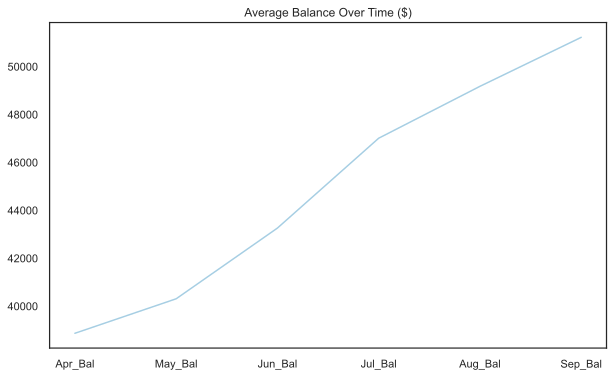

In [148]:
# Average balance over time
bal_months = ['Apr_Bal', 'May_Bal', 'Jun_Bal',
              'Jul_Bal', 'Aug_Bal', 'Sep_Bal']
avg_bal = []

for month in bal_months:
    avg_bal.append(df[month].mean())

plt.figure(figsize=(10,6))
plt.plot(bal_months, avg_bal)
plt.title('Average Balance Over Time ($)')
plt.show();

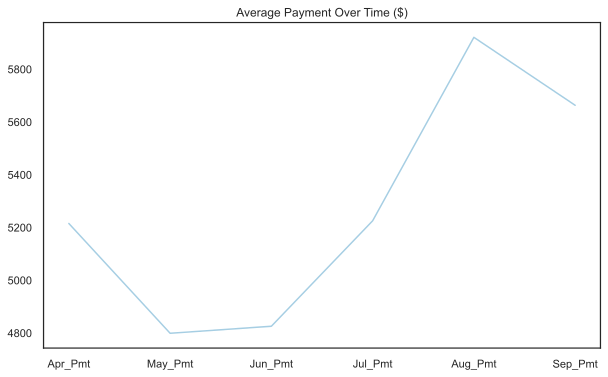

In [149]:
# Average payment over time
monthly_payments = ['Apr_Pmt', 'May_Pmt', 'Jun_Pmt',
                    'Jul_Pmt', 'Aug_Pmt', 'Sep_Pmt']
avg_pmt = []

for month in monthly_payments:
    avg_pmt.append(df[month].mean())

plt.figure(figsize=(10,6))
plt.plot(monthly_payments, avg_pmt)
plt.title('Average Payment Over Time ($)')
plt.show();

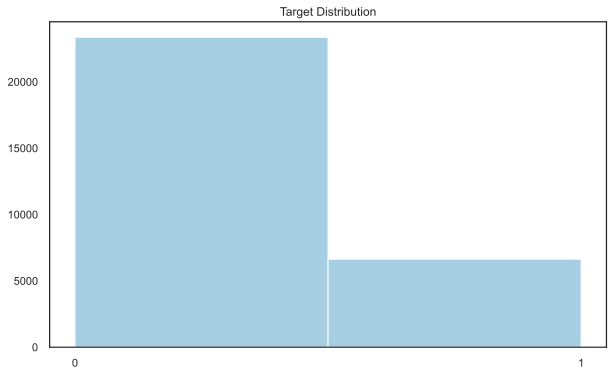

In [50]:
# The data is highly imbalanced
plt.figure(figsize=(10,6))
plt.hist(df['Default'], bins=2)
plt.title('Target Distribution')
plt.xticks([0,1])
plt.show();

Highly imbalanced dataset

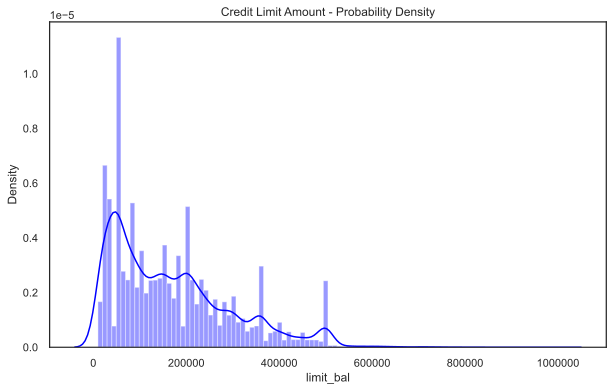

In [20]:
# Distribution of limit balance
plt.figure(figsize = (10,6))
plt.title('Credit Limit Amount - Probability Density')
plt.ticklabel_format(style='plain', axis='x')
sns.distplot(df['limit_bal'],kde=True,bins=100, color="blue")
plt.show();

In [21]:
# Top Credit Limit Amounts in our distribution
df['limit_bal'].value_counts().head()

50000     3365
20000     1976
30000     1610
80000     1567
200000    1528
Name: limit_bal, dtype: int64

Largest Credit Limit Amount groups are 50k, 20k, and 30k

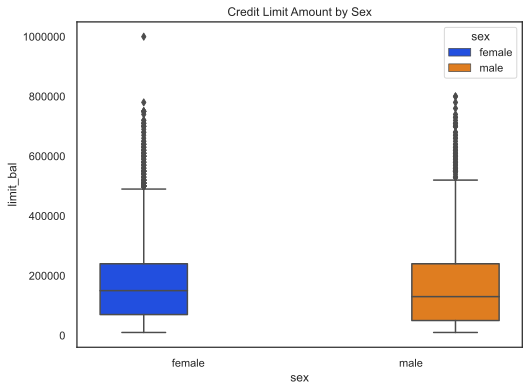

In [29]:
# Credit Limit vs Sex
plt.figure(figsize = (8,6))
plt.title('Credit Limit Amount by Sex')
plt.ticklabel_format(style='plain', axis='y')
sns.boxplot(x='sex', y='limit_bal', hue='sex', data=df, palette='bright')
plt.show();

Credit limit amount is evenly distributed amongst males and females

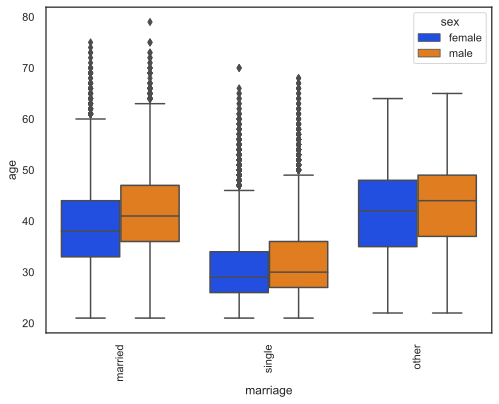

In [63]:
# Marriage, Age, and Sex
def boxplot_variation(feature1, feature2, feature3, width=16):
    fig, ax1 = plt.subplots(ncols=1, figsize=(width, 6))
    s = sns.boxplot(ax=ax1, x=feature1, y=feature2, hue=feature3,
                    data=df, palette='bright')
    s.set_xticklabels(s.get_xticklabels(), rotation=90)
    plt.show();

boxplot_variation('marriage', 'age', 'sex', 8)

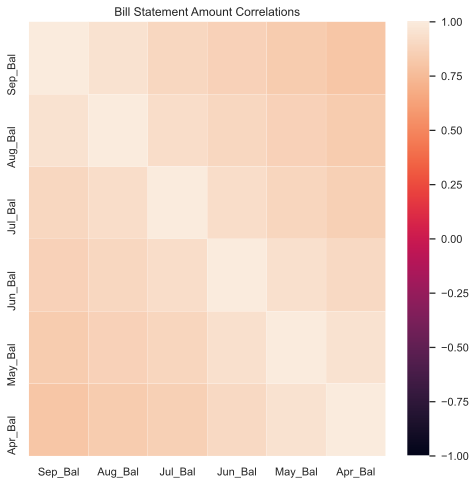

In [73]:
# Amount of Bill Statement
# Correlation Plot
values = list(column_names['balance_names'].values())

plt.figure(figsize=(8,8))
plt.title('Bill Statement Amount Correlations')
corr = df[values].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=0.1, vmin=-1, vmax=1)
plt.show();

Correlation between months becomes stronger the closer the months are in time.

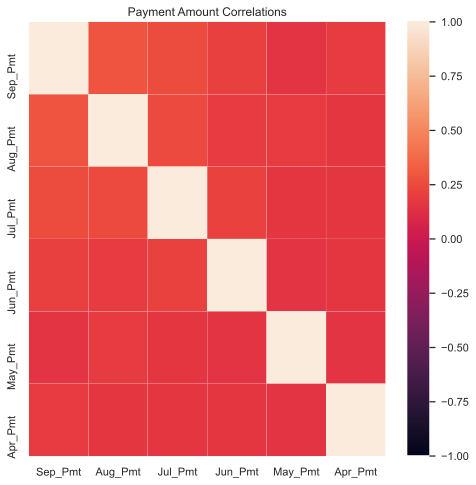

In [75]:
# Amount of Previous Payment
# Correlation Plot
values = list(column_names['payment_names'].values())

plt.figure(figsize=(8,8))
plt.title('Payment Amount Correlations')
corr = df[values].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=0.1, vmin=-1, vmax=1)
plt.show();

No correlation between payment amount months

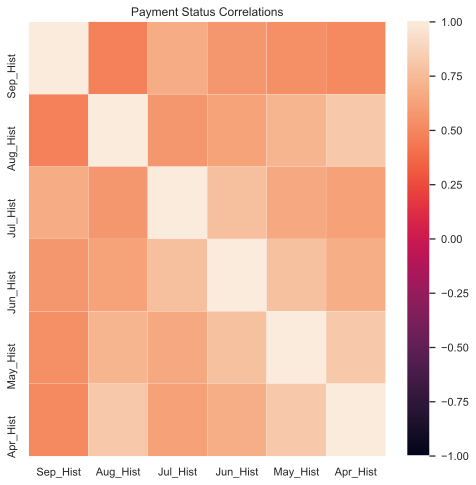

In [77]:
# Payment Status
# Correlation Plot
values = list(column_names['history_names'].values())

plt.figure(figsize=(8,8))
plt.title('Payment Status Correlations')
corr = df[values].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=0.1, vmin=-1, vmax=1)
plt.show();

Correlation gets stronger the closer the months are in time.

# Minimal Viable Product

Let's test several models to get a base model to proceed with further testing

## Features and target variables

In [143]:
X = df.loc[:,'limit_bal':'Apr_Pmt']
y = df['Default']

## Encode Categorical Variables

In [144]:
categoricals = list(X.select_dtypes('object').columns)
numericals = list(X.select_dtypes('int64').columns)

def encode_cats(categoricals, numericals):
    """
    Takes in a list of categorical columns and a list of numerical columns and returns the dataframe with encoded variables
    """
    ohe = OneHotEncoder(sparse=False, drop='first')
    cat_matrix = ohe.fit_transform(X.loc[:, categoricals])
    X_ohe = pd.DataFrame(cat_matrix,
                         columns=ohe.get_feature_names(categoricals), #create meaningful column names
                         index=X.index) #keep the same index values
    
    return pd.concat([X.loc[:, numericals], X_ohe], axis=1)

In [145]:
X = encode_cats(categoricals, numericals)

## Split the Data

In [82]:
def train_test_val_split(X, y):
    """
    Input: X --> array of features, y --> target array
           set aside for testing.
    Output: Features and target split into train, val and test sets. 
            Test size = 20%
            Val size = 25%
            Converted to numpy arrays.
    """
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Split train/validate sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

    # Convert to numpy arrays to help with generate indeces below
    X, y = np.array(X), np.array(y)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [146]:
X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_split(X, y)

In [147]:
def scale_data(X_train, X_val, X_test):
    """
    Input: Features (numpy arrays)
    Output: Scaled data
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_val_scaled, X_test_scaled

In [148]:
X_train_scaled, X_val_scaled, X_test_scaled = scale_data(X_train, X_val, X_test)

In [149]:
def model_score(model_name, model, X_train_scaled, X_val_scaled,
                X_test_scaled, y_train, y_val, y_test, test=False):
    """
    Input: Transformed feature and target sets
    Output: Validation scores. If test=True, includes test scores
    """
    print('Calculating validation score...')

    my_model = model
    my_model.fit(X_train_scaled,y_train)
    print(f'{model_name} accuracy score: {my_model.score(X_val_scaled,y_val):.4}\n')

    if test:
        print("Calculating test score...")
        print(f'{model_name} accuracy score: {my_model.score(X_test_scaled,y_test):.4}\n')

    return my_model

In [87]:
knn = model_score('KNN', KNeighborsClassifier(n_neighbors=5),
                       X_train_scaled,X_val_scaled, X_test_scaled,
                       y_train, y_val, y_test,test=False)

lr = model_score('LogReg', LogisticRegression(penalty='none'),
                       X_train_scaled,X_val_scaled, X_test_scaled,
                       y_train, y_val, y_test,test=False)

rf = model_score('RF', RandomForestClassifier(),
                       X_train_scaled,X_val_scaled, X_test_scaled,
                       y_train, y_val, y_test,test=False)
        
gbm = model_score('XGBoost', xgb.XGBClassifier(),
                       X_train_scaled,X_val_scaled, X_test_scaled,
                       y_train, y_val, y_test,test=False)

svc = model_score('SVM', SVC(probability=True),
                       X_train_scaled,X_val_scaled, X_test_scaled,
                       y_train, y_val, y_test,test=False)

Calculating validation score...
KNN accuracy score: 0.7938

Calculating validation score...
LogReg accuracy score: 0.8158

Calculating validation score...
RF accuracy score: 0.8168

Calculating validation score...
XGBoost accuracy score: 0.8192

Calculating validation score...
SVM accuracy score: 0.8193



Support Vector Machine performs the best with an accuracy of 0.8193. However, we will move forward with Random Forest because it is less computationally expensive.

# Performance Metrics

## Confusion Matrix

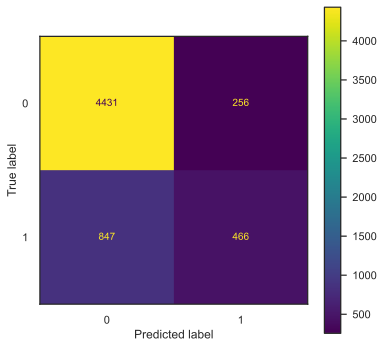

In [88]:
fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(rf, X_test_scaled, y_test, ax=ax);

## Classification Report

In [89]:
y_preds_rf = rf.predict(X_test_scaled)
print(classification_report(y_test, y_preds_rf))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4687
           1       0.65      0.35      0.46      1313

    accuracy                           0.82      6000
   macro avg       0.74      0.65      0.67      6000
weighted avg       0.80      0.82      0.79      6000



# Optimization

What are we optimizing for? In this case, we are optimizing recall. Recall is a performance metric which attempts to answer the question: What proportion of actual positives was identified correctly? Mathematically, the formula is

$RecallScore = \frac{TP}{TP + FN}$

TP = True Positive, or a correctly predicted default

FN = False Negative, or an incorrectly predicted non-default

Ideally, we do not want to miss any potentially defaults to fall through the cracks, so our optimal model will minimize False Negatives (optimize Recall Score)

# Feature Selection
There are many feature selection scores one could perform to determine
which features are most useful. For this case, we will use Feature Importance.

Feature Importance is the process of assigning scores to each feature, depending on how useful it is in predicting the target variable

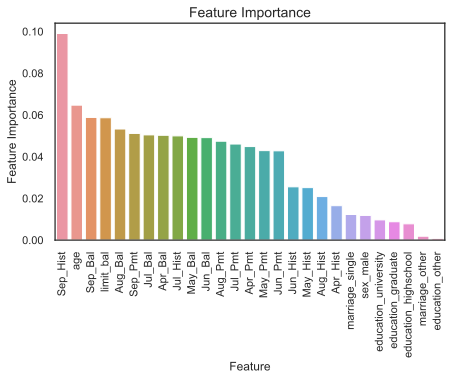

In [100]:
temp = pd.DataFrame({'Feature': list(X.columns), 'Feature Importance': rf.feature_importances_})
temp = temp.sort_values(by="Feature Importance", ascending=False)

plt.figure(figsize=(7,4))
plt.title('Feature Importance', fontsize=14)
s=sns.barplot(x='Feature', y='Feature Importance', data=temp)
s.set_xticklabels(s.get_xticklabels(), rotation=90)
plt.show();

The top features are shown in the chart. It's interesting how 'age' is the second most important feature. Let's keep all of them except the last 6, the categorical variables.

In [150]:
# Update dataframe
X = X.iloc[:, np.argsort(rf.feature_importances_,)[7:]]

# Hyperparamter Tuning
Let's search for optimal parameters for our model

In [123]:
# Define parameter values that should be searched
bootstrap = [True, False]
max_features = ['auto','sqrt']
min_samples_leaf = [1,2,4]
min_samples_split = [2,5,10]
n_estimators = [50,100,150,200]
max_depth = [4,6,10,12, None]

In [124]:
# Specify "parameter distributions" rather than a "parameter grid"

param_dist = dict(n_estimators=n_estimators, max_depth = max_depth, bootstrap=bootstrap,
                  min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split,
                  max_features=max_features)
print(param_dist)

{'n_estimators': [50, 100, 150, 200], 'max_depth': [4, 6, 10, 12, None], 'bootstrap': [True, False], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10], 'max_features': ['auto', 'sqrt']}


In [125]:
# n_iter controls the number of searches

rand = RandomizedSearchCV(RandomForestClassifier(), param_dist, cv=10, scoring='accuracy',
                          n_iter=10, random_state=42)
rand.fit(X_train_scaled, y_train)

# Uncomment line below to print
# rand.cv_results_

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [4, 6, 10, 12, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 150, 200]},
                   random_state=42, scoring='accuracy')

In [126]:
def get_best_model(model_grid):
    best_k = model_grid.cv_results_['rank_test_score'][0]
    print (f"Mean score: {model_grid.cv_results_['mean_test_score'][best_k]}",
           f"Std: {model_grid.cv_results_['std_test_score'][best_k]}")

In [127]:
# Examine the best model
print(rand.best_score_)
print(rand.best_params_)
get_best_model(rand)

0.820888888888889
{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 6, 'bootstrap': False}
Mean score: 0.820888888888889 Std: 0.008097400893778688


We found optimal parameters, not a huge improvement, but anything helps

# Class Imbalance

## Under/Oversampling

In [151]:
def over_under_sample(X_train, y_train, Under=True, Over=True):
    """
    Input: training features and target
    Output: under/oversampled datasets
    """
    rus = RandomUnderSampler(random_state=42)
    ros = RandomOverSampler(random_state=42)

    if Under and Over:
        X_train_under, y_train_under = rus.fit_sample(X_train, y_train)
        X_train_over, y_train_over = ros.fit_sample(X_train, y_train)
        return X_train_under, y_train_under, X_train_over, y_train_over
    elif Under:
        X_train_under, y_train_under = rus.fit_sample(X_train, y_train)
        return X_train_under, y_train_under
    else:
        X_train_over, y_train_over = ros.fit_sample(X_train, y_train)
        return X_train_over, y_train_over

In [154]:
# Split data
X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_split(X, y)

# Random under/over sampling
X_train_under, y_train_under, X_train_over, y_train_over = over_under_sample(X_train, y_train, Under=True, Over=True)


## Undersampling

In [155]:
# Scale
X_train_scaled_under, X_val_scaled, X_test_scaled = scale_data(X_train_under, X_val, X_test)

# Score
rf_under = model_score('RF', RandomForestClassifier(**rand.best_params_),
                 X_train_scaled_under, X_val_scaled, X_test_scaled,
                 y_train_under, y_val, y_test, test=False)

Calculating validation score...
RF accuracy score: 0.7593



In [156]:
y_preds = rf_under.predict(X_test_scaled)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      4687
           1       0.46      0.63      0.53      1313

    accuracy                           0.75      6000
   macro avg       0.67      0.71      0.68      6000
weighted avg       0.79      0.75      0.77      6000



## Oversampling

In [157]:
# Scale
X_train_scaled_over, X_val_scaled, X_test_scaled = scale_data(X_train_over, X_val, X_test)

# Score
rf_over = model_score('RF', RandomForestClassifier(**rand.best_params_),
                 X_train_scaled_over, X_val_scaled, X_test_scaled,
                 y_train_over, y_val, y_test, test=False)

Calculating validation score...
RF accuracy score: 0.7763



In [158]:
# Classification report
y_preds = rf_over.predict(X_test_scaled)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      4687
           1       0.48      0.60      0.53      1313

    accuracy                           0.77      6000
   macro avg       0.68      0.71      0.69      6000
weighted avg       0.79      0.77      0.78      6000



Overall accuracy decreased by about 0.04, and recall decreased by about 0.10. However, precision increased by 0.18. That may be good or bad, depending on what costs more. Is it more costly to incorrectly predict true defaults, or is it more costly to incorrectly identifythose who will not default? That is up to management to decide.

# Analyze Results

## Final Model

In [135]:
print("Random Forest with the following parameters:\n")
print(rand.best_params_)

Random Forest with the following parameters:

{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 6, 'bootstrap': False}


Sometimes the best model is the simplest. The model with minimal manipulation yielded the highest recall score of 0.95. After feature selection and hyperparameter tuning, recall decreased to 0.79.

Let's check for overfitting. Overfitting means the model is strong at predicting the data it was trained, but weak at generalizing to unseen data. Lets test the model on never-before-seen data points and see how it performs

## Check for Overfitting

In [161]:
# features and target
X = df.loc[:,'limit_bal':'Apr_Pmt']
y = df['Default']

# encode categorical

X = encode_cats(categoricals, numericals)

# Split data
X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_split(X, y)

# Scale
X_train_scaled, X_val_scaled, X_test_scaled = scale_data(X_train, X_val, X_test)

# Model score
rf = model_score('RF', RandomForestClassifier(**rand.best_params_),
                 X_train_scaled, X_val_scaled, X_test_scaled,
                 y_train, y_val, y_test, test=True)

Calculating validation score...
RF accuracy score: 0.8208

Calculating test score...
RF accuracy score: 0.8217



Validation score and test score are similar so there is no sign overfitting

## F-Beta Score

In [137]:
print(f"f-beta score: {fbeta_score(y_test, rf_over.predict(X_test_scaled), average='weighted', beta=5.0):.4}")

f-beta score: 0.7735


## ROC Curve

ROC AUC score =  0.7747459348189829


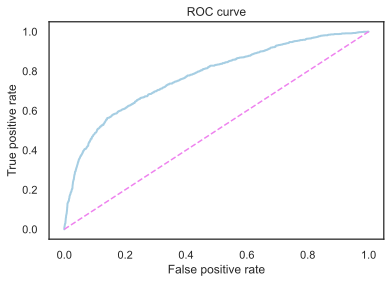

In [138]:
fpr, tpr, thresholds = roc_curve(y_test, rf_over.predict_proba(X_test_scaled)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test, rf_over.predict_proba(X_test_scaled)[:,1]))